In [1]:
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt
import csv

In [56]:
class Perceptron(object):
    def __init__(self):
        self.W1 = None
        self.b1 = 0
        self.W2 = None
        self.b2 = 0
    
    def load_data(self):
        with open('xor.dat','r') as f:
            data = [i.strip().split(',') for i in f.readlines()]
        data = np.array(data, dtype=np.float16)
        data = data.astype(int)
        return data  
    
    def hypothesis(self, X, w=None, b=None):
#         print('hypothesis X:', X)
#         print('hypothesis w:', w)
        f = np.dot(X,w) + b
        f = np.exp(f)
        denom = f.sum(axis=1)
        for i in range(len(denom)):
            f[i,:] /= denom[i]
        return f
    
    def forward(self, X):
        hidden = self.hypothesis(X, self.W1, self.b1)
        output = self.hypothesis(hidden, self.W2, self.b2)
        return hidden, output
    
    def loss(self, p, y, w=None, lamb=0.9):        
        return -1 * (np.sum(y*np.log(p))/len(y) + (lamb/2) * (np.sum(np.square(self.W1)) + np.sum(np.square(self.W2))))
    
    def gradients(self, X, hidden, Y, step_size=0.8):
        z, p = self.forward(X)
        
        dj_dw2 = np.dot(hidden.T, (p - Y))
        dj_db2 = sum(p - Y)
        
        dj_db1 = np.multiply(np.dot(self.W2, sum(p-Y)), 1-hidden*hidden)
        dj_dw1 = np.dot(X.T, dj_db1)
        
        result = np.array([[dj_dw2, dj_db2],
                           [dj_dw1, dj_db1]])
        return result
    
    def secant_approx(self, x, y, epsilon=10e-3):
        
        w1 = self.W1.flatten()
        b1 = self.b1.flatten()
        theta1 = np.concatenate((w1, b1))
        delta_w_a1 = []
        
        for i in range(len(theta1)):
            theta1[i] += epsilon
            self.W1 = theta1[:len(w1)].reshape(self.W1.shape)
            self.b1 = theta1[-len(b1):].reshape(self.b1.shape)
            z, p = self.forward(x)
#             j_plus = np.multiply(np.dot(self.w2,sum(p-Y)), 1-z*z)
            j_plus = self.loss(p, y)
            theta1[i] -= 2*epsilon
            self.W1 = theta1[:len(w1)].reshape(self.W1.shape)
            self.b1 = theta1[-len(b1):].reshape(self.b1.shape)
            z, p = self.forward(x)
#             j_minus = np.multiply(np.dot(self.W2,sum(p-y)), 1-z*z)
            j_minus = self.loss(p,y)
            theta1[i] += epsilon
            dj_dtheta1 = (j_plus - j_minus)/(2*epsilon)
            delta_w_a1.append(dj_dtheta1)
        
        w1 = np.asarray(delta_w_a1[:len(w1)]).reshape(self.W1.shape)
        b1 = np.asarray(delta_w_a1[-len(b1):]).reshape(self.b1.shape)  
        
        w2 = self.W2.flatten()
        b2 = self.b2.flatten()
        theta2 = np.concatenate((w2,b2))
        delta_w_a2 = []
        
        for j in range(len(theta2)):
#             backup = theta[j]
            theta2[j] += epsilon
            self.W2 = theta2[:len(w2)].reshape(self.W2.shape)
            self.b2 = theta2[-len(b2):].reshape(self.b2.shape)
            z, p = self.forward(x)
            j_plus = self.loss(p, y)
#             theta[j] = backup
            theta2[j] -= 2*epsilon
            self.W2 = theta2[:len(w2)].reshape(self.W2.shape)
            self.b2 = theta2[-len(b2):].reshape(self.b2.shape)
            z, p = self.forward(x)
            j_minus = self.loss(p, y)
            theta2[j] += epsilon
            dj_dtheta2 = (j_plus - j_minus)/(2*epsilon)
            delta_w_a2.append(dj_dtheta2)
#             theta = backup            
        w2 = np.asarray(delta_w_a2[:len(w2)]).reshape(self.W2.shape)
        b2 = np.asarray(delta_w_a2[-len(b2):]).reshape(self.b2.shape)
        
        
        result = np.array([[w2, b2],
                          [w1, b1]])
        return result

    
    def train(self, X, Y):
        epochs = 100
        losses_per_epoch = []

        Z, p = self.forward(X)
        print('Initial prediction:', p)
        J = self.loss(p, Y)
        for i in range(epochs):           
            if J < 0.1:
                print('loss is minimum i.e.', J)
                break
            z_train, py_train = self.forward(X)
#             z_valid, py_valid = self.forward(Xvalid)

            self.w2 -= step_size * np.dot(z_train.T, (py_train - Y))
            self.b2 -= step_size * sum(py_train - Y)
            
            dj_by_dz = np.multiply(np.dot((py_train - Y), self.w2.T), (1-z_train*z_train))
            self.w1 -= step_size * np.dot(X.T, dj_by_dz)
            self.b1 -= step_size * sum(dj_by_dz)
            Z, p = self.forward(X)
            J = self.loss(p, Y)
            losses_per_epoch.append(J)
        print('Final prediction:', p)
        correct = 0
        total = 0
        for i in range(len(p)):
            if np.argmax(Y[i]) == np.argmax(p[i]):
                correct += 1
            total += 1
        print('accuracy = ', (correct/total)*100)
        %matplotlib notebook
        plt.plot(losses_per_epoch)
        plt.title('Losses per epoch')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.plot()
        plt.show()
    
    def compare(self, num_h_units):
        data = self.load_data()

        X, Y = data[:, :-1], data[:, -1]
        N, D = X.shape
        k = len(np.unique(Y))
        ind = np.zeros((N, k))
        for i in range(N):
            ind[i, Y[i]] = 1
        Y = ind
        X = X.astype(float)
        
#         self.W1 = np.random.normal(scale=1/D**0.5, size=(D,3))
#         self.b1 = np.random.normal(scale=1/k**0.5, size=3)
        
#         self.W2 = np.random.normal(scale=1/D**0.5, size=(3, k))
#         self.b2 = np.random.normal(scale=1/k**0.5, size=k)
        np.random.seed(1)
        self.W1 = np.random.normal(0, 1, (D, num_h_units)) # 2x2
        self.W2 = np.random.normal(0, 1, (num_h_units, k)) # 1x2

        self.b1 = np.random.random(num_h_units) # 2x1
        self.b2 = np.random.random(k) # 1x1
        
        print('W1:', self.W1)
        print('W2:', self.W2)
        print('b1:', self.b1)
        print('b2:', self.b2)
        
        hidden, output = self.forward(X)
        print('Hidden:', hidden)
        print('Output:', output)
        print('Y:', Y)
        
        delta_a = self.gradients(X, hidden, Y)
        delta_n = self.secant_approx(X, Y)
        
        diff2 = delta_a[0][0] - delta_n[0][0]
        diff1 = delta_a[1][0] - delta_n[1][0]
        print('Difference between analytical and numerical weights:')
        print('delta_W2:', diff2)
        print('delta_W1:', diff1)
        for i in range(len(diff2)):
            for j in range(len(diff2[i])):
                if abs(diff2[i,j]) > 1e-4:
                    print('not correct')
#                     return
        for i in range(len(diff1)):
            for j in range(len(diff1[i])):
                if abs(diff1[i,j]) > 1e-4:
                    print('not correct')
#                     return
        print('Difference between weights is correct')
        
        diff2 = delta_a[0][1] - delta_n[0][1]
        diff1 = delta_a[1][1] - delta_n[1][1]
        print('Difference between analytical and numerical biases:')
        print('delta_b2:', diff2)
        print('delta_b1:', diff1)
        for i in range(len(diff2)):
            for j in range(len(diff2[i])):
                if abs(diff2[i,j]) > 1e-4:
                    print('not correct')
#                     return
        for i in range(len(diff1)):
            for j in range(len(diff1[i])):
                if abs(diff1[i,j]) > 1e-4:
                    print('not correct')
#                     return
        print('Difference between biases is correct')
        self.train(X, Y)

W1: [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
W2: [[ 1.74481176 -0.7612069 ]
 [ 0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071]]
b1: [0.14038694 0.19810149 0.80074457]
b2: [0.96826158 0.31342418]
Hidden: [[0.25031935 0.26519146 0.48448919]
 [0.74732245 0.08461483 0.16806272]
 [0.11202267 0.82451231 0.06346502]
 [0.53982682 0.42463816 0.03553502]]
Output: [[0.95848786 0.04151214]
 [0.95960036 0.04039964]
 [0.83586371 0.16413629]
 [0.91483748 0.08516252]]
Y: [[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]
Difference between analytical and numerical weights:
delta_W2: [[ 2.1361324  -1.25088802]
 [ 0.82953874 -0.76683689]
 [ 1.4592842  -1.9975137 ]]
delta_W1: [[ 6.28190067  1.19776356 11.06765127]
 [ 6.10034157  1.91938127  9.62085496]]
not correct
not correct
not correct
not correct
not correct
not correct
not correct
not correct
not correct
not correct
not correct
not correct
Difference between weights is correct
Difference between analytical and numerical bi

<IPython.core.display.Javascript object>


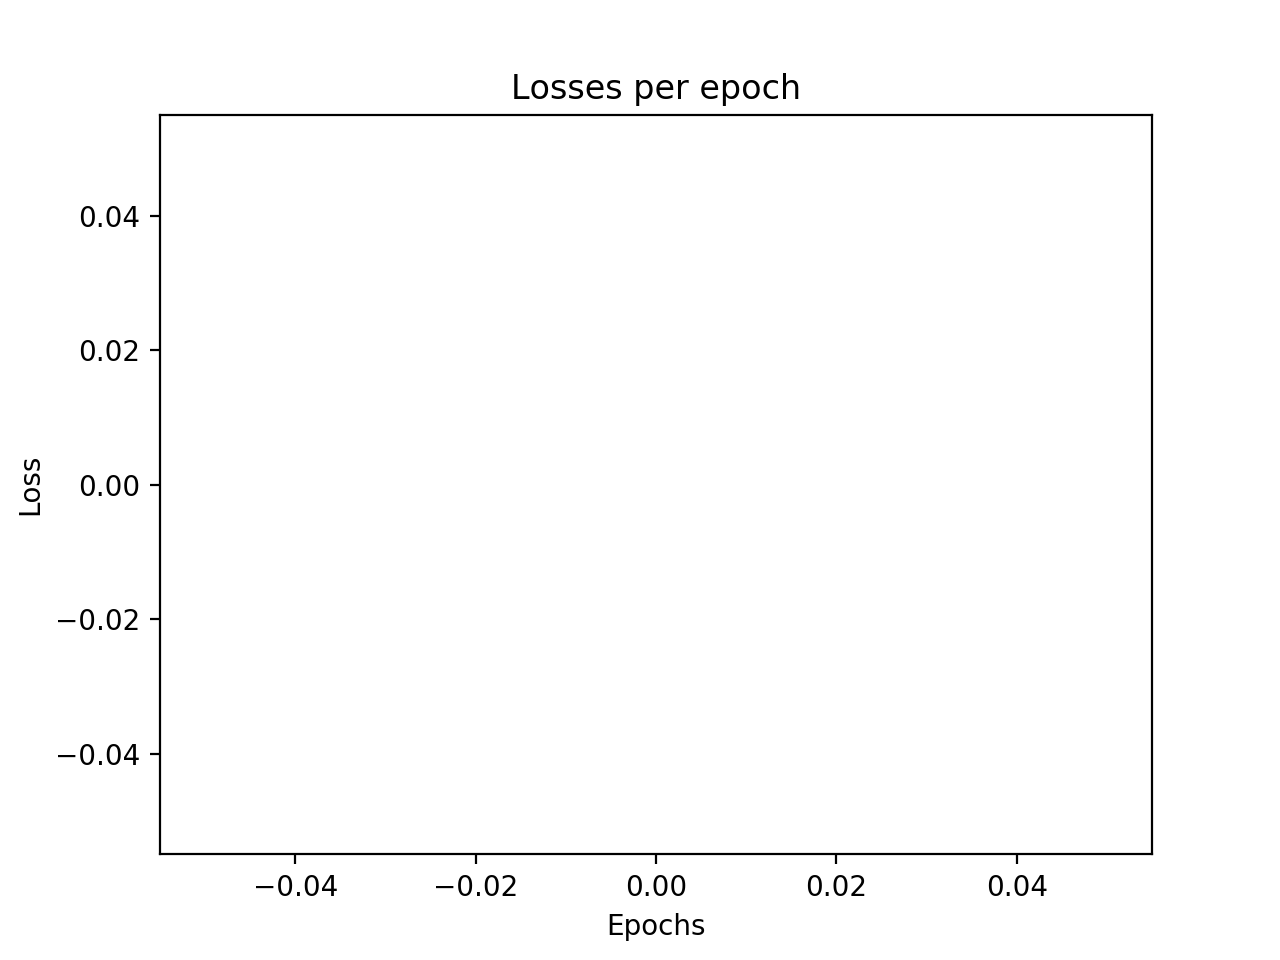

In [57]:
net = Perceptron()
net.compare(3)